# Time Series Extraction

In [1]:
import xarray as xr
import cf_xarray
import extract_model as em
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import cmocean.cm as cmo

## Example model to use

In [2]:
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t12z.nc
# !wget https://www.ncei.noaa.gov/thredds/fileServer/model-ciofs-files/2022/03/nos.ciofs.fields.n001.20220301.t18z.nc

In [3]:
# Structured: CIOFS: ROMS Cook Inlet model
# get some model output locally
loc1 = glob('nos.ciofs.*.nc')


# # Unstructured: CREOFS: SELFE Columbia River model
# today = pd.Timestamp.today()
# loc2 = [today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n000.%Y%m%d.t03z.nc'),
#         today.strftime('https://opendap.co-ops.nos.noaa.gov/thredds/dodsC/NOAA/CREOFS/MODELS/%Y/%m/%d/nos.creofs.fields.n001.%Y%m%d.t03z.nc')]


In [4]:
ds1 = xr.open_mfdataset(loc1, preprocess=em.preprocess)
ds1

<xarray.Dataset>
Dimensions:          (boundary: 4, eta_psi: 1043, eta_rho: 1044, eta_u: 1044, eta_v: 1043, ocean_time: 2, s_rho: 30, s_w: 31, tracer: 2, xi_psi: 723, xi_rho: 724, xi_u: 723, xi_v: 724)
Coordinates: (12/21)
  * s_rho            (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w              (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.03333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(1044, 724), meta=np.ndarray>
    lon_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    lat_u            (eta_u, xi_u) float64 dask.array<chunksize=(1044, 723), meta=np.ndarray>
    ...               ...
  * eta_psi          (eta_psi) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042
  * eta_rho          (eta_rho) int64 0 1 2 3 4 5 ... 1039 1040 1041 1042 1043
  * eta_u            (eta_u) int64 0 1 2 3 4 5 ... 1038 1039 1040 1041 1042 1043
  * eta_v            (eta_v) int64 0 1 2 3 4 5 ... 1037 1038 1039 1040 1041 1042
    z_rho            (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    z_w              (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
Dimensions without coordinates: boundary, tracer
Data variables: (12/78)
    ntimes           (ocean_time) int32 5400 5400
    ndtfast          (ocean_time) int32 10 10
    dt               (ocean_time) float64 4.0 4.0
    dtfast           (ocean_time) float64 0.4 0.4
    dstart           (ocean_time) datetime64[ns] 2022-03-01T06:00:00 2022-03-...
    nHIS             (ocean_time) int32 900 900
    ...               ...
    w                (ocean_time, s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 31, 1044, 724), meta=np.ndarray>
    temp             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    salt             (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 30, 1044, 724), meta=np.ndarray>
    Pair             (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Uwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
    Vwind            (ocean_time, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 1044, 724), meta=np.ndarray>
Attributes: (12/32)
    file:              nos.ciofs.fields.nowcast.20220301.t12z_0002.nc
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             ciofs nowcast RUN in operational mode
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /usrx/local/prod/intel/2018UP01/compilers_and_librarie...
    compiler_flags:    -fp-model precise -ip -xHost
    tiling:            026x028
    history:           ROMS/TOMS, Version 3.9, Tuesday - March 1, 2022 - 12:5...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_ra...
    CPP_options:       mode, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BTFLUX, AN...

## Demo code

### Select time series from nearest point

Name a DataArray specifically since when there are multiple horizontal grids (like there are for ROMS models), it's too complicated to use the Dataset.

In [5]:
da1 = ds1['temp']
lon0, lat0 = -151.4, 59  # cook inlet

For any of the following results, access the depth values with

```
[output].cf['vertical'].values
```

#### 2D lon/lat

The first request will take longer than a second request would because the second request uses the indices found the first time.

In [6]:
output = da1.em.sel2d(lon0, lat0)
output

<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 30)>
dask.array<getitem, shape=(2, 30), dtype=float32, chunksize=(1, 30), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    xi_rho      int64 259
    eta_rho     int64 21
    z_rho       (ocean_time, s_rho) float64 dask.array<chunksize=(1, 30), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    standard_name:  sea_water_temperature

Access the associated indices, which are remembered:

In [7]:
j, i = da1.em.argsel2d_map[(lon0,lat0)]

Profile for first time matches:

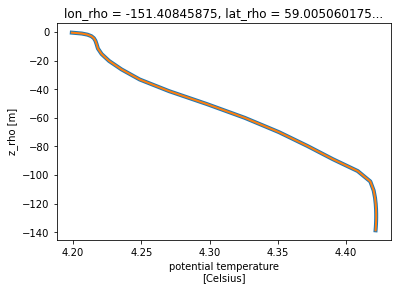

In [8]:
output.cf.isel(T=0).cf.plot(y='vertical', lw=4)
da1.cf.isel(X=i, Y=j, T=0).cf.plot(y='vertical', lw=2)

Surface value for first time matches map:

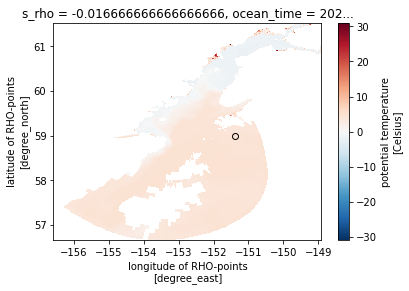

In [9]:
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude')
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=mappable.cmap, vmin=vmin, vmax=vmax, edgecolors='k')

In [10]:
output

<xarray.DataArray 'temp' (ocean_time: 2, s_rho: 30)>
dask.array<getitem, shape=(2, 30), dtype=float32, chunksize=(1, 30), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    xi_rho      int64 259
    eta_rho     int64 21
    z_rho       (ocean_time, s_rho) float64 dask.array<chunksize=(1, 30), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    standard_name:  sea_water_temperature

To retrieve the values:

`output.values`

In [11]:
output.values

array([[4.4214993, 4.421684 , 4.4218173, 4.421909 , 4.4219575, 4.421951 ,
        4.4218597, 4.4216237, 4.421123 , 4.4200873, 4.4176564, 4.408428 ,
        4.3901873, 4.371695 , 4.350696 , 4.325884 , 4.297998 , 4.270254 ,
        4.248803 , 4.2355056, 4.226392 , 4.2209353, 4.218213 , 4.2172427,
        4.216388 , 4.2152452, 4.213435 , 4.2106075, 4.206378 , 4.199108 ],
       [4.424722 , 4.4244523, 4.4241757, 4.4238887, 4.423582 , 4.4232464,
        4.422875 , 4.4224715, 4.42206  , 4.421729 , 4.421524 , 4.4213953,
        4.421301 , 4.4212065, 4.421026 , 4.4203506, 4.417338 , 4.4085073,
        4.393578 , 4.377725 , 4.365008 , 4.353777 , 4.33955  , 4.3348207,
        4.332366 , 4.3302   , 4.3278446, 4.3250537, 4.321379 , 4.315123 ]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [12]:
output.cf['vertical'].values

array([[-138.64620096, -136.45404081, -134.29685074, -132.08256877,
        -129.70712397, -127.05153545, -123.98048995, -120.34392005,
        -115.98372281, -110.74806061, -104.51500367,  -97.22473876,
         -88.9147529 ,  -79.74653062,  -70.00912942,  -60.08933079,
         -50.4111136 ,  -41.36259349,  -33.23552631,  -26.19551996,
         -20.28570287,  -15.45354835,  -11.58622257,   -8.54299833,
          -6.17914801,   -4.36054596,   -2.97074644,   -1.91298718,
          -1.10926786,   -0.49803671],
       [-138.64664128, -136.45533117, -134.29897758, -132.08555423,
        -129.71103055, -127.05647178, -123.98661711, -120.35145735,
        -115.99295084, -110.75931885, -104.52867887,  -97.24124086,
         -88.93447733,  -79.76981016,  -70.03618479,  -60.1202327 ,
         -50.44576839,  -41.40075697,  -33.27684118,  -26.2395647 ,
         -20.33203924,  -15.50175845,  -11.63593229,   -8.5938881 ,
          -6.2309544 ,   -4.41305754,   -3.02379693,   -1.96644783,
         

#### 3D lon/lat/Z or iZ

Return model output nearest to lon, lat, Z value.

In [13]:
da1.em.sel2d(lon0, lat0, Z=-40)

<xarray.DataArray 'temp' (ocean_time: 2)>
dask.array<concatenate, shape=(2,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.4167
    lon_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    xi_rho      int64 259
    eta_rho     int64 21
    z_rho       (ocean_time) float64 -41.36 -41.4
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    standard_name:  sea_water_temperature

Return model output nearest to lon, lat, at index iZ in Z dimension.

In [14]:
da1.em.sel2d(lon0, lat0, iZ=-1)

<xarray.DataArray 'temp' (ocean_time: 2)>
dask.array<getitem, shape=(2,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.01667
    lon_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
    lat_rho     float64 dask.array<chunksize=(), meta=np.ndarray>
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    xi_rho      int64 259
    eta_rho     int64 21
    z_rho       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    long_name:      potential temperature
    units:          Celsius
    time:           ocean_time
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    standard_name:  sea_water_temperature

### Interpolate time series at exact point

In [15]:
da1 = ds1['salt']
lon0, lat0 = -152, 58
lons, lats = [-151, -152], [59,58]

#### 2D lon/lat

1 lon/lat pair

In [16]:
%%time
output = da1.em.interp2d(lon0, lat0)
output

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 16.9 s, sys: 495 ms, total: 17.4 s
Wall time: 17.6 s


<xarray.DataArray 'salt' (ocean_time: 2, s_rho: 30)>
dask.array<getitem, shape=(2, 30), dtype=float32, chunksize=(1, 30), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    lon         int64 -152
    lat         int64 58
    z_rho       (ocean_time, s_rho) float64 dask.array<chunksize=(1, 30), meta=np.ndarray>
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

Surface value for first time matches map:

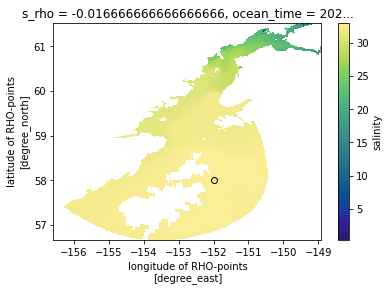

In [17]:
cmap=cmo.haline
mappable = da1.cf.isel(T=0, Z=-1).cf.plot(x='longitude', y='latitude', cmap=cmap)
vmin, vmax = mappable.get_clim()
plt.scatter(lon0, lat0, c=output.cf.isel(T=0, Z=-1).values, cmap=cmap, vmin=vmin, vmax=vmax, edgecolors='k')

To retrieve the values:

`output.values`

In [18]:
output.values

array([[32.93971 , 32.939648, 32.939594, 32.93954 , 32.939472, 32.939392,
        32.939293, 32.93917 , 32.93898 , 32.93863 , 32.937885, 32.936424,
        32.933247, 32.92608 , 32.918026, 32.910328, 32.903812, 32.898037,
        32.892227, 32.88485 , 32.877373, 32.875435, 32.875843, 32.87596 ,
        32.875977, 32.875988, 32.875996, 32.875996, 32.87599 , 32.875977],
       [32.935272, 32.935257, 32.93523 , 32.9352  , 32.93515 , 32.93508 ,
        32.934994, 32.934853, 32.934593, 32.934105, 32.93326 , 32.931606,
        32.92794 , 32.921555, 32.913635, 32.905594, 32.898544, 32.892017,
        32.88495 , 32.876884, 32.87071 , 32.868958, 32.86884 , 32.86886 ,
        32.86887 , 32.868885, 32.868904, 32.86892 , 32.868946, 32.86898 ]],
      dtype=float32)

To retrieve the associated depths:

`output.cf['vertical'].values`

In [19]:
output.cf['vertical'].values

array([[-170.93673211, -168.23867249, -165.58365323, -162.85836659,
        -159.9347245 , -156.66628805, -152.88651681, -148.41071134,
        -143.0442822 , -136.60035119, -128.92884998, -119.95616184,
        -109.72842493,  -98.44439063,  -86.45982418,  -74.25076722,
         -62.33904308,  -51.20233542,  -41.19973055,  -32.53505482,
         -25.26138969,  -19.31408652,  -14.55427209,  -10.80874262,
          -7.89937074,   -5.66107772,   -3.95054486,   -2.64867942,
          -1.65948041,   -0.90719136],
       [-170.93469594, -168.23270543, -165.573818  , -162.84456081,
        -159.91665917, -156.64346084, -152.85818274, -148.37585633,
        -143.00160868, -136.54828932, -128.86561127, -119.87985055,
        -109.63721254,  -98.33673819,  -86.33471107,  -74.10786637,
         -62.17878768,  -51.02585461,  -41.00867665,  -32.33137709,
         -25.04711474,  -19.09114677,  -14.32439762,  -10.57341118,
          -7.65980055,   -5.4182465 ,   -3.7052215 ,   -2.40145934,
         

multiple lon/lat pairs

In [20]:
%%time
da1.em.interp2d(lons, lats)

/Users/kthyng/miniconda3/envs/extract_model/lib/python3.9/site-packages/dask/array/core.py:378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


CPU times: user 15.8 s, sys: 416 ms, total: 16.3 s
Wall time: 16.5 s


<xarray.DataArray 'salt' (ocean_time: 2, s_rho: 30, lat: 2, lon: 2)>
dask.array<_regrid, shape=(2, 30, 2, 2), dtype=float32, chunksize=(1, 30, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
  * lon         (lon) int64 -151 -152
  * lat         (lat) int64 59 58
    z_rho       (ocean_time, s_rho, lat, lon) float64 dask.array<chunksize=(1, 30, 2, 2), meta=np.ndarray>
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

#### 3D: lon, lat, iZ

Return model output interpolated to lon, lat, Z value.

In [21]:
da1.em.interp2d(lon0, lat0, Z=-40)

<xarray.DataArray 'salt' (ocean_time: 2)>
dask.array<concatenate, shape=(2,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    s_rho       (ocean_time) float64 -0.3787 -0.3795
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    lon         int64 -152
    lat         int64 58
    z_rho       int64 -40
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

Return model output interpolated to lon, lat, at index iZ in Z dimension.

In [22]:
da1.em.interp2d(lon0, lat0, iZ=-1)

<xarray.DataArray 'salt' (ocean_time: 2)>
dask.array<getitem, shape=(2,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    s_rho       float64 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 2022-03-01T07:00:00 2022-03-01T13...
    lon         int64 -152
    lat         int64 58
    z_rho       (ocean_time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    long_name:      salinity
    time:           ocean_time
    grid:           grid
    location:       face
    field:          salinity, scalar, series
    standard_name:  sea_water_practical_salinity
    regrid_method:  bilinear

Note that it is not currently possible to interpolate in depth when there are both multiple times and locations.

In [23]:
da1.em.interp2d(lons, lats, Z=-40)

NotImplementedError: Currently it is not possible to interpolate in depth with more than 1 other (time) dimension.